In [49]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

doping_df = pd.read_csv('final_doping.csv')

k = 8.617E-5

def etch(t_before: float, thickness, rate, time) -> float:
    if thickness is not None:
        return t_before - thickness
    return t_before - rate * time

def growth(t_before: float, coeffs: dict, temp: float, time: float):
    temp_K = temp + 273.15
    B = coeffs['B']['C'] * np.e**(-coeffs['B']['E'] / (k * temp_K))
    A = B / (coeffs['BA']['C'] * np.e**(-coeffs['BA']['E'] / (k * temp_K)))
    tao = t_before**2 / B + t_before * A / B
    return A / 2 * (np.sqrt(1 + 4 * B * (time + tao) / A**2) - 1)

def anomalous_init_growth(t_before: float, coeffs: dict, temp: float, time: float):
    kT = k * (temp + 273.15)
    B = coeffs['B']['C'] * np.e**(-coeffs['B']['E'] / kT)
    A = B / (coeffs['BA']['C'] * np.e**(-coeffs['BA']['E'] / kT))
    C = coeffs['C']['C'] * np.e**(-coeffs['C']['E'] / kT)
    for _ in range(100_000):
        rate = B / (2 * t_before + A) + C * np.e**(- t_before / coeffs['L'])
        t_before += rate * time / 100000
    return t_before


etch_rates = {'HF': .005, 'BOE': .09, 'H3PO4': .00008, 'lampoly':.0026}
# etch rates in um/min
# H3PO4: https://docs.google.com/document/u/1/d/e/2PACX-1vQtS04u0g_7KlHcDGjUSU6CiqKIt9KRuvyCWMLoNZ6COQZo5yJ1qz92b8JhDlDEuxJ89oDiKV9BbsB8/pub
# HF/BOE: https://docs.google.com/document/u/1/d/e/2PACX-1vT13QQJ9jdz8HbkyAtxnrrnP58OJj_ENp0-IafUzgY5rtkdAeXc7V3ezCJjxLh1gMhJZTXJxIaKJu58/pub
# lampoly: https://snfexfab.stanford.edu/docs/operating-instructions/lampoly-operating-instructions
growth_coeffs = {'wet': {'B': {'C': 7.0, 'E': .78}, 'BA': {'C': 2.95E6 / 1.68, 'E': 2.05}},
                 'dry': {'B': {'C': 12.87, 'E': 1.23}, 'BA': {'C': 1.04E5 / 1.68, 'E': 2.0}, 'C': {'C': 6.5E6, 'E': 2.37}, 'L': .007}}

In [69]:
### Gate Oxide Thickness
# slap some euler on that bad boy
t_gate_ox = anomalous_init_growth(0, growth_coeffs['dry'], 900, 20)
print("Gate oxide thickness, um", t_gate_ox)

### LOCOS
t_locos = growth(0, growth_coeffs['wet'], 850, 12) # 1.1
t_locos = etch(t_locos, None, etch_rates['HF'], .5) # 2.79
t_locos = growth(t_locos, growth_coeffs['wet'], 1000, 100) # 2.8
locos_depth = t_locos / 2.2
t_locos = etch(t_locos, None, etch_rates['BOE'], .75) # 2.85
t_locos = etch(t_locos, None, etch_rates['H3PO4'], 85) # 2.9
t_locos = etch(t_locos, None, etch_rates['HF'], .5) # 2.93
locos_depth += (growth(t_locos, growth_coeffs['wet'], 850, 15) - t_locos) / 2.2
t_locos = growth(t_locos, growth_coeffs['wet'], 850, 15) # 2.95
t_locos = etch(t_locos, None, etch_rates['HF'], .5) # 3.0
t_locos = etch(t_locos, None, etch_rates['HF'], 11) # 3.05
locos_depth += (growth(t_locos, growth_coeffs['dry'], 900, 20) - t_locos) / 2.2
t_locos = growth(t_locos, growth_coeffs['dry'], 900, 20) # 3.15
t_parasitic_locos = t_locos
print('LOCOS thickness with poly on top, um', t_locos)
t_locos = etch(t_locos, None, etch_rates['HF'], .5) # 3.7
t_locos = etch(t_locos, None, etch_rates['HF'], .5) # 3.9
print('Pre LTO Thickness, um', t_locos)
t_locos += .6
t_locos = etch(t_locos, None, etch_rates['HF'], .5) # 4.7
print('Final Thickness, um', t_locos)

Gate oxide thickness, um 0.007904392299248568
LOCOS thickness with poly on top, um 0.4538838294968199
Pre LTO Thickness, um 0.4488838294968199
Final Thickness, um 1.04638382949682


In [51]:
def calc_tao(Q, R, temp):
    return 4 * np.pi * (2.7E-8)**3 * R * Q / 51 * np.e**(3.57 / (k * (temp + 273.15)))

def I_supersat(temp):
    return 1.22E-2 * np.e**(1.19 / (k * (temp + 273.15)))

def calc_enh_Dt(var, coeffs, f_i, temp, Q_311, R):
    tao = calc_tao(Q_311, R, temp)
    I_sat = I_supersat(temp)
    D = I_sat * f_i * calc_D_reg(coeffs, temp)
    return var + 2 * D * tao

def calc_ni(temp):
    return np.sqrt(1.52E33 * (temp+273.15)**3 * np.e**(-1.21 / (k * (temp+273.15))))

def calc_D_reg(coeffs, temp):
    return coeffs[3][0] * np.e**(-coeffs[3][1] / (k * (temp + 273.15)))

def calc_D_concentration(c_p, coeffs, temp, background):
    ni = calc_ni(temp)
    ratio = (c_p + background) / ni
    if ratio < 0:
        ratio = - 1 / ratio
    tao = k * (temp + 273.15)
    return (coeffs[0][0] * np.e**(-coeffs[0][1] / tao) +
            ratio * coeffs[1][0] * np.e**(-coeffs[1][1] / tao) +
            ratio**2 * coeffs[2][0] * np.e**(-coeffs[2][1] / tao))

def calc_cp(Q, var, delta):
    if delta:
        return Q / np.sqrt(np.pi * var / 2)
    return Q / np.sqrt(2 * np.pi * var)
            
def calc_Dt(var, coeffs, temp, temp_ramp, time):
    for ii in range(time):
        D = calc_D_reg(coeffs, temp + temp_ramp * ii)
        var += 2 * D * 60
    return var

up_rate = 10
down_rate = 6
delay = 10

def calc_ramped_Dt(var, coeffs, start_temp, end_temp, dwell_time):
    var = calc_Dt(var, P_coeffs, start_temp, up_rate, int((end_temp-start_temp) / up_rate))
    var = calc_Dt(var, P_coeffs, end_temp, 0, 10)
    var = calc_Dt(var, P_coeffs, end_temp, 0, dwell_time)
    var = calc_Dt(var, P_coeffs, end_temp, 0, 10)
    var = calc_Dt(var, P_coeffs, end_temp, -down_rate, int((end_temp-start_temp) / down_rate))
    return var

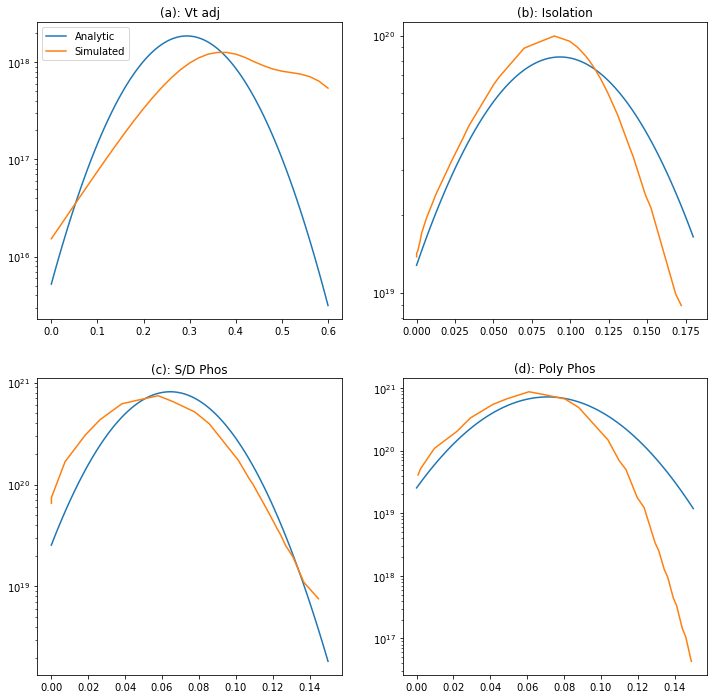

In [52]:
# S/D implants -- Rp = .0608um. Amorphhizes to 111nm
poly_Q = 5E15
poly_R = 7.17E-6 * np.cos(7 * np.pi / 180)
poly_var = (2.75E-6)**2


SD_Q = poly_Q
SD_R = (poly_R - t_gate_ox * 1E-4 + etch_rates['HF'] * .5 * 1E-4) * np.cos(7 * np.pi / 180)
wafer_bg = 1E15
SD_var = (2.45E-6)**2

# Vt Adjust Implant -- Rp=.2887um. Does not amorphize
VT_var = (8.57E-6)**2
VT_Q = 4E13
VT_R = 2.96E-5 * np.cos(7 * np.pi / 180)
B_coeffs = [[.05, 3.5], [.95, 3.5], [0, 0], [1, 3.5]]

# Isolation implant -- Rp = .09675um, but first must pierce SiO2 layer. Does not amorphize
iso_var = (4.83E-6)**2
iso_Q = 1E15
iso_R = (1.14E-5 - 2e-6) * np.cos(7 * np.pi / 180)

def doping_at_depth(Q, peak, var, depth, one_sided):
    cp = calc_cp(Q, var, one_sided)
    if one_sided:
        return cp * np.e**(-(depth)**2 / (2 * var))
    return cp * np.e**(-(depth-peak)**2 / (2 * var))

fig, axs = plt.subplots(2, 2, figsize=(12, 12))


axs[0,0].set_title('(a): Vt adj')
axs[0,0].set_yscale('log')
zs = np.linspace(0, .6, 100)
cp = calc_cp(VT_Q,VT_var, False)
vt_cs = [cp * np.e**(-(z*1E-4 - VT_R)**2 / (2 * VT_var)) for z in zs]
axs[0,0].plot(zs, vt_cs, label='Analytic')

offset = 0
vt_sim = doping_df[['impl_vt_depth', 'impl_vt_c']]
vt_sim = vt_sim[vt_sim['impl_vt_depth'].between(zs[0] - offset, zs[-1] - offset)]
axs[0,0].plot(vt_sim['impl_vt_depth'], vt_sim['impl_vt_c'], label='Simulated')
axs[0,0].legend()

axs[0,1].set_title('(b): Isolation')
axs[0,1].set_yscale('log')
zs = np.linspace(0, .18, 100)
cp = calc_cp(iso_Q,iso_var, False)
iso_cs = [cp * np.e**(-(z*1E-4 - iso_R)**2 / (2 * iso_var)) for z in zs]
axs[0,1].plot(zs, iso_cs, label='Analytic')

offset = -.009
iso_sim = doping_df[['impl_iso_depth', 'impl_iso_c']]
iso_sim = iso_sim[iso_sim['impl_iso_depth'].between(zs[0] - offset, zs[-1] - offset)]
axs[0,1].plot(iso_sim['impl_iso_depth']+offset, iso_sim['impl_iso_c'], label='Simulated')

axs[1,0].set_title('(c): S/D Phos')
axs[1,0].set_yscale('log')
zs = np.linspace(0, .15, 100)
cp = calc_cp(SD_Q,SD_var, False)
SD_cs = [cp * np.e**(-(z*1E-4 - SD_R)**2 / (2 * SD_var)) for z in zs]
axs[1,0].plot(zs, SD_cs, label='Analytic')

offset = -.021
sd_sim = doping_df[['impl_sd_depth', 'impl_sd_c']]
sd_sim = sd_sim[sd_sim['impl_sd_depth'].between(zs[0] - offset, zs[-1] - offset)]
axs[1,0].plot(sd_sim['impl_sd_depth']+offset, sd_sim['impl_sd_c'], label='Simulated')

axs[1,1].set_title('(d): Poly Phos')
axs[1,1].set_yscale('log')
zs = np.linspace(0, .15, 100)
cp = calc_cp(poly_Q,poly_var, False)
poly_cs = [cp * np.e**(-(z*1E-4 - poly_R)**2 / (2 * poly_var)) for z in zs]
axs[1,1].plot(zs, poly_cs, label='Analytic')

offset = .237
poly_sim = doping_df[['impl_poly_depth', 'impl_poly_c']]
poly_sim = poly_sim[poly_sim['impl_poly_depth'].between(zs[0] - offset, zs[-1] - offset)]
axs[1,1].plot(poly_sim['impl_poly_depth']+offset, poly_sim['impl_poly_c'], label='Simulated')

#fig.tight_layout()

In [53]:
P_coeffs = [[1000*3.85, 3.66], [1000*4.44, 4], [1000*44.2, 4.37], [1000*4.7, 3.68]]
poly_var = calc_enh_Dt(poly_var, P_coeffs, 1, 800, 1E14, 1.11E-5)
poly_var = calc_ramped_Dt(poly_var, P_coeffs, 800, 950, 30)
print('Poly Stdev, um', np.sqrt(poly_var) * 1E4)

P_coeffs = [[3.85, 3.66], [4.44, 4], [44.2, 4.37], [4.7, 3.68]]

VT_var = calc_enh_Dt(VT_var, B_coeffs, 1, 800, VT_Q, VT_R)
VT_var = calc_ramped_Dt(VT_var, B_coeffs, 800, 850, 12)

VT_iso_var = calc_enh_Dt(VT_var, B_coeffs, 1, 800, iso_Q, iso_R)
iso_var = calc_enh_Dt(iso_var, B_coeffs, 1, 800, iso_Q, iso_R)

VT_iso_var = calc_ramped_Dt(VT_iso_var, B_coeffs, 800, 1000, 100)
iso_var = calc_ramped_Dt(iso_var, B_coeffs, 800, 1000, 100)
VT_var = calc_ramped_Dt(VT_var, B_coeffs, 800, 1000, 100)

VT_iso_var = calc_ramped_Dt(VT_iso_var, B_coeffs, 800, 850, 15)
iso_var = calc_ramped_Dt(iso_var, B_coeffs, 800, 850, 15)
VT_var = calc_ramped_Dt(VT_var, B_coeffs, 800, 850, 15)

VT_iso_var = calc_ramped_Dt(VT_iso_var, B_coeffs, 800, 900, 20)
iso_var = calc_ramped_Dt(iso_var, B_coeffs, 800, 900, 20)
VT_var = calc_ramped_Dt(VT_var, B_coeffs, 800, 900, 20)

VT_channel_var = VT_var
VT_var = calc_enh_Dt(VT_var, B_coeffs, 1, 800, 1E14, 1.11E-5)
SD_var = calc_enh_Dt(SD_var, P_coeffs, 1, 800, 1E14, 1.11E-5)


VT_iso_var = calc_ramped_Dt(VT_iso_var, B_coeffs, 800, 950, 30)
iso_var = calc_ramped_Dt(iso_var, B_coeffs, 800, 950, 30)
SD_var = calc_ramped_Dt(SD_var, P_coeffs, 800, 950, 30) # 4E17 due to Vt adjust implant
VT_var = calc_ramped_Dt(VT_var, B_coeffs, 800, 950, 30)
VT_channel_var = calc_ramped_Dt(VT_channel_var, B_coeffs, 800, 950, 30)

print('S/D Stdev, um', SD_R*1E4, np.sqrt(SD_var) * 1E4)
print('S/D VT Stdev, um', VT_R*1E4, np.sqrt(VT_var) * 1E4)
print('ISO Stdev, um', iso_R*1E4, np.sqrt(iso_var) * 1E4)

Poly Stdev, um 3.0931933720594964
S/D Stdev, um 0.06449293970611879 0.10083322362670369
S/D VT Stdev, um 0.2937936608858313 0.22871455151512263
ISO Stdev, um 0.09329933825428427 0.3408447753736175


Analytic Junction Depth, um 0.3666666666666667
Simulated Junction Depth, um 0.975958


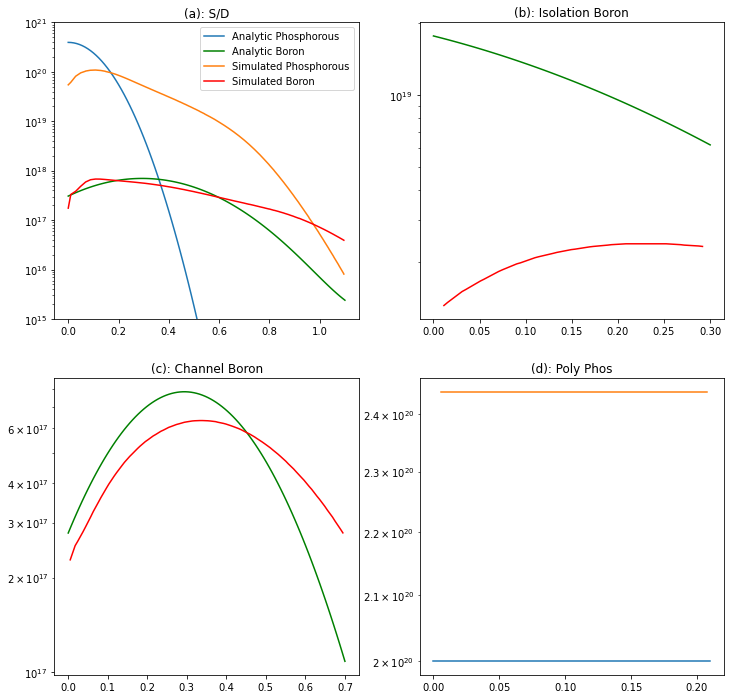

In [55]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

axs[0,0].set_title('(a): S/D')
axs[0,0].set_yscale('log')
zs = np.linspace(0, 1.1, 100)
phos_cs = [doping_at_depth(SD_Q, SD_R, SD_var, z*1E-4, True) for z in zs]
axs[0,0].plot(zs, phos_cs, label='Analytic Phosphorous')
boron_cs = [doping_at_depth(VT_Q, VT_R, VT_var, z*1E-4, False) + 1e15 for z in zs]
axs[0,0].plot(zs, boron_cs, label='Analytic Boron', color='g')

net_cs = [p - b for (p, b) in zip (phos_cs, boron_cs)]
(junc_depth, _) = next((z, c) for (z, c) in zip(zs, net_cs) if c < 0)
print('Analytic Junction Depth, um', junc_depth)


offset = -.049
sd_sim = doping_df[['sd_boron_depth', 'sd_boron_c', 'sd_phos_c']]
sd_sim = sd_sim[sd_sim['sd_boron_depth'].between(zs[0] - offset, zs[-1] - offset)]
axs[0,0].plot(sd_sim['sd_boron_depth'] + offset, sd_sim['sd_phos_c'], label='Simulated Phosphorous')
axs[0,0].plot(sd_sim['sd_boron_depth'] + offset, sd_sim['sd_boron_c'], label='Simulated Boron', color='r')
axs[0,0].set_ylim([1e15, 1e21])
axs[0,0].legend()

net_cs = sd_sim['sd_phos_c'] - sd_sim['sd_boron_c']
(junc_depth, _) = next((z + offset, c) for (z, c) in zip(sd_sim['sd_boron_depth'], net_cs) if c < 0)
print('Simulated Junction Depth, um', junc_depth)

axs[0,1].set_title('(b): Isolation Boron')
axs[0,1].set_yscale('log')
zs = np.linspace(locos_depth, locos_depth + .3, 100)
iso_cs = [doping_at_depth(iso_Q, iso_R, iso_var, z*1E-4, True) + doping_at_depth(VT_Q, VT_R, VT_iso_var, z*1E-4, False) + 1e15 for z in zs]
axs[0,1].plot(np.array(zs) - locos_depth, iso_cs, label='Analytic', color='g')
iso_analytic_c = iso_cs[0]

offset = locos_depth - .265
iso_sim = doping_df[['poly_para_boron_depth', 'poly_para_boron_c']]
iso_sim = iso_sim[iso_sim['poly_para_boron_depth'].between(zs[0] - offset, zs[-1] - offset)]
axs[0,1].plot(iso_sim['poly_para_boron_depth']-.265, iso_sim['poly_para_boron_c'], label='Simulated', color='r')
iso_sim_c = iso_sim['poly_para_boron_c'].iloc[0]

axs[1,0].set_title('(c): Channel Boron')
axs[1,0].set_yscale('log')
zs = np.linspace(0, .7, 100)
cs = [doping_at_depth(VT_Q, VT_R, VT_channel_var, z*1E-4, False) + 1e15 for z in zs]
axs[1,0].plot(zs, cs, label='Analytic Boron', color='g')
channel_analytic_c = cs[0]


offset = -.022
channel_sim = doping_df[['device_boron_depth', 'device_boron_c']]
channel_sim = channel_sim[channel_sim['device_boron_depth'].between(zs[0] - offset, zs[-1] - offset)]
axs[1,0].plot(channel_sim['device_boron_depth'] + offset, channel_sim['device_boron_c'], label='Simulated Boron', color='r')
channel_sim_c = channel_sim['device_boron_c'].iloc[0]

axs[1,1].set_title('(d): Poly Phos')
axs[1,1].set_yscale('log')
zs = np.linspace(0, .21, 100)
cs = [poly_Q / (.25 * 1e-4) for z in zs]
axs[1,1].plot(zs, cs, label='Analytic Phosphorous')
poly_analytic_c = cs[0]

offset = .204
poly_sim = doping_df[['device_phos_depth', 'device_phos_c']]
poly_sim = poly_sim[poly_sim['device_phos_depth'].between(zs[0] - offset, zs[-1] - offset)]
axs[1,1].plot(poly_sim['device_phos_depth']+offset, poly_sim['device_phos_c'], label='Simulated Phosphorous')
poly_sim_c = poly_sim['device_phos_c'].iloc[0]

In [16]:
# Calc threshold voltages
Eg = 1.124
kTdivq = .0259
Nc = 2.86E19
Nv = 3.10E19
ni = np.sqrt(Nc * Nv * np.e**(- Eg / kTdivq))
W_Ti = 4.33
Chi_Si = 4.05

epsilon_naught = 8.85E-14
q = 1.6E-19
epsilon_ox = 3.9 * epsilon_naught
epsilon_s = 11.7 * epsilon_naught
Q_f = 1e10

# main transistor
Cox = epsilon_ox / (t_gate_ox * 1E-4)
Nd = poly_analytic_c
Na = channel_analytic_c
W_cg_dif = kTdivq * (np.log(Nd / Nc) + np.log(Na / Nv)) + Eg
phi_st = 2 * kTdivq * np.log(Na / ni)
gamma = np.sqrt(2 * epsilon_s * q * Na) / Cox
vt = -W_cg_dif + phi_st + gamma * np.sqrt(phi_st) - q * Q_f / Cox
print("Main transistor Analytical Vt", vt)
print("xmax", np.sqrt(2 * epsilon_s * phi_st / (q * Na)) * 1e4)

# main transistor sim
Cox = epsilon_ox / (.009 * 1E-4)
Nd = poly_sim_c
Na = channel_sim_c
W_cg_dif = kTdivq * (np.log(Nd / Nc) + np.log(Na / Nv)) + Eg
print(Eg/2 - kTdivq * np.log(Nd/Nc))
phi_st = 2 * kTdivq * np.log(Na / ni)
gamma = np.sqrt(2 * epsilon_s * q * Na) / Cox
vt = -W_cg_dif + phi_st + gamma * np.sqrt(phi_st) - q * Q_f / Cox
print("Main transistor Simulated Vt", vt)

# Parasite over LOCOS analytic
Cox = epsilon_ox / (t_parasitic_locos * 1E-4)
Na = iso_analytic_c
Nd = poly_analytic_c
W_cg_dif = kTdivq * (np.log(Nd / Nc) + np.log(Na / Nv)) + Eg
phi_st = 2 * kTdivq * np.log(Na / ni)
gamma = np.sqrt(2 * epsilon_s * q * Na) / Cox
vt = -W_cg_dif + phi_st + gamma * np.sqrt(phi_st) - q * Q_f / Cox
print("Parasite 1 analytic Vt", vt)

# Parasite over LOCOS sim
Cox = epsilon_ox / (.4616 * 1E-4)
Na = iso_sim_c
Nd = poly_sim_c
W_cg_dif = kTdivq * (np.log(Nd / Nc) + np.log(Na / Nv)) + Eg
phi_st = 2 * kTdivq * np.log(Na / ni)
gamma = np.sqrt(2 * epsilon_s * q * Na) / Cox
vt = -W_cg_dif + phi_st + gamma * np.sqrt(phi_st) - q * Q_f / Cox
print("Parasite 1 sim Vt", vt)

# Parasite of metal to LOCOS analytic
Cox = epsilon_ox / (t_locos * 1E-4)
Na = iso_analytic_c
W_cg_dif = Chi_Si + Eg + kTdivq * np.log(Na / Nv) - W_Ti
phi_st = 2 * kTdivq * np.log(Na / ni)
gamma = np.sqrt(2 * epsilon_s * q * Na) / Cox
vt = -W_cg_dif + phi_st + gamma * np.sqrt(phi_st) - q * Q_f / Cox
print("Parasite 2 analytic Vt", vt)

# Parasite of metal to LOCOS sim
Cox = epsilon_ox / (1.0464 * 1E-4)
Na = iso_sim_c
W_cg_dif = Chi_Si + Eg + kTdivq * np.log(Na / Nv) - W_Ti
phi_st = 2 * kTdivq * np.log(Na / ni)
gamma = np.sqrt(2 * epsilon_s * q * Na) / Cox
vt = -W_cg_dif + phi_st + gamma * np.sqrt(phi_st) - q * Q_f / Cox
print("Parasite 2 sim Vt", vt)

Main transistor Analytical Vt 0.5367582580666642
xmax 0.0645486558609913
0.5064765769565945
Main transistor Simulated Vt 0.484284144060738
Parasite 1 analytic Vt 332.5656563844659
Parasite 1 sim Vt 86.42783025167803
Parasite 2 analytic Vt 767.1093941314
Parasite 2 sim Vt 196.42984392838423


In [8]:
mu_1 = 80
mu_2 = 1360
N_0 = 8E16
alpha = .75

mu_1 = 55.24
mu_2 = 1388 - 55.24
N_0 = 1.072E17
alpha = .733


def mu_doping(N):
    return mu_1 + mu_2 / (1 + (N / N_0) ** alpha)

def sheet_resistance(distributions, depth):
    denom = 0
    zs = np.linspace(0, depth, 1000)
    for z in zs:
        net_doping = 0
        total_doping = 0
        for distr in distributions:
            if len(distr) == 2:
                dope = distr[0]
            else:
                dope = doping_at_depth(distr[0], distr[1], distr[2], z, distr[3])
            net_doping += dope * distr[-1]
            total_doping += dope
        denom += depth / 1000 * net_doping * mu_doping(total_doping)
    return 1 / (q * denom)


SD_distr = [SD_Q, SD_R, SD_var, True, 1]
VT_distr = [VT_Q, VT_R, VT_var, False, -1]
background_distr = [1e15, -1]
rho_sheet_ds = sheet_resistance([SD_distr, VT_distr, background_distr], junc_depth * 1E-4)
print("S/D sheet resistance, Ohms/square", rho_sheet_ds)

sd_sim['net_cs'] = sd_sim['sd_phos_c'] - sd_sim['sd_boron_c']
sd_sim['total_cs'] = sd_sim['sd_phos_c'] + sd_sim['sd_boron_c']
last_z = -.049
denom = 0
for index, row in sd_sim.iterrows():
    if row['net_cs'] < 0:
        break
    denom += (row['sd_boron_depth'] - last_z) * 1E-4 * row['net_cs'] * mu_doping(row['total_cs'])
    last_z = row['sd_boron_depth']
print("Gate sheet resistance, Ohms/square",  1 / (q * denom))

gate_doping = poly_Q / .25E-4
rho_sheet_gate = 1 / (q * poly_Q * mu_doping(gate_doping) / 2)
print("Gate sheet resistance, Ohms/square", rho_sheet_gate)

sim_gate_doping = poly_Q / .217E-4
sim_rho_sheet_gate = 1 / (q * poly_Q * mu_doping(sim_gate_doping) / 2)
print("Gate sheet resistance analytic, Ohms/square", sim_rho_sheet_gate)

NameError: name 'junc_depth' is not defined

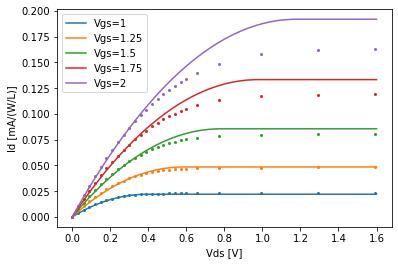

In [80]:
# main transistor
Cox = epsilon_ox / (t_gate_ox * 1E-4)
Nd = poly_analytic_c
Na = channel_analytic_c
W_cg_dif = kTdivq * (np.log(Nd / Nc) + np.log(Na / Nv)) + Eg
phi_st = 2 * kTdivq * np.log(Na / ni)
gamma = np.sqrt(2 * epsilon_s * q * Na) / Cox
vt = -W_cg_dif + phi_st + gamma * np.sqrt(phi_st) - q * Q_f / Cox
mu = mu_doping(Na)


current_df = pd.read_csv('id_vd.csv')



def Id(mu, C, V_gs, Vt, gamma, phi_st, V_ds, V_fb):
    V_dssat = V_gs - Vt + gamma * np.sqrt(phi_st) - gamma**2 / 2 * (np.sqrt(1 + 4 / gamma**2 * (V_gs - V_fb)) - 1)
    V_ds = min(V_dssat, V_ds)
    V_ds = max(V_ds, 0)
    part_1 = V_ds * (V_gs - Vt + gamma * np.sqrt(phi_st) - V_ds / 2)
    part_2 = - 2 / 3 * gamma * ((phi_st + V_ds)**(3/2) - (phi_st)**(3/2))
    return mu * C * (part_1 + part_2) * 1000


vgss = [1, 1.25, 1.5, 1.75, 2]
vdss = np.linspace(0, 1.6, num=41)
plt.figure()
for vgs in vgss:
    Ids = [Id(mu, Cox, vgs, vt, gamma, phi_st, vds, -W_cg_dif) for vds in vdss]
    plt.plot(vdss, Ids, label=f'Vgs={vgs}')

for col in current_df.columns:
    if 'vg' in col:
        plt.scatter(current_df['vds'], current_df[col] * 2 * 1000, s=4)

plt.xlabel('Vds [V]')
plt.ylabel('Id [mA/(W/L)]')
plt.legend()
